In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%tensorflow_version 1.4

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.lib.io import file_io

import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Activation,Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from sklearn.metrics import confusion_matrix
from seaborn import heatmap

%matplotlib inline

Using TensorFlow backend.


In [4]:
EPOCHS = 150
BS = 128
DROPOUT_RATE = 0.4
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

In [5]:
model = Sequential()
model.add(BatchNormalization(input_shape=(48,48,1)))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(48,48,1),name="conv1"))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool1"))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same',name="conv2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv3"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv4"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool4"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024, activation='relu',name='fc1'))
model.add(Dropout(DROPOUT_RATE))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax',name='fcsoftmax'))

#TODO: weight decay of 0.0001...initial learning rate is set to 0.01 and reduced by a factor of 2 at every 25 epoch
sgd = SGD(lr=SGD_LEARNING_RATE,momentum=0.9, decay=SGD_DECAY, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [6]:
cp_filepath='/content/drive/MyDrive/Colab Notebooks/models/Baseline-weights-best.hdf5'
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(cp_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [rlrop,checkpoint]

In [7]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/My Drive/Colab Notebooks/dataset/train.zip' -d train

In [8]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/Colab Notebooks/dataset/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/My Drive/Colab Notebooks/dataset/test-private.zip' -d test

In [9]:
%%bash
root='/content/train/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

0 angry: 3995
1 disgust: 436
2 fear: 4097
3 happy: 7215
4 sad: 4830
5 surprise: 3171
6 neutral: 4965


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(48, 48),
            color_mode='grayscale',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [11]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')
test_generator  = get_datagen('/content/test')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [12]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    #steps_per_epoch=28709// BS,
    #validation_steps=3509 // BS,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=callbacks_list,
#    callbacks=[rlrop],
    use_multiprocessing=False,
)


Epoch 1/150
225/225 [==============================] - 28s 123ms/step - loss: 2.0042 - accuracy: 0.2554 - val_loss: 2.3319 - val_accuracy: 0.1819

Epoch 00001: val_accuracy improved from -inf to 0.18194, saving model to /content/drive/MyDrive/Colab Notebooks/models/Baseline-weights-best.hdf5
Epoch 2/150
225/225 [==============================] - 19s 86ms/step - loss: 1.7991 - accuracy: 0.3034 - val_loss: 1.6757 - val_accuracy: 0.3644

Epoch 00002: val_accuracy improved from 0.18194 to 0.36445, saving model to /content/drive/MyDrive/Colab Notebooks/models/Baseline-weights-best.hdf5
Epoch 3/150
225/225 [==============================] - 20s 89ms/step - loss: 1.7176 - accuracy: 0.3397 - val_loss: 1.1674 - val_accuracy: 0.4202

Epoch 00003: val_accuracy improved from 0.36445 to 0.42017, saving model to /content/drive/MyDrive/Colab Notebooks/models/Baseline-weights-best.hdf5
Epoch 4/150
225/225 [==============================] - 20s 88ms/step - loss: 1.6441 - accuracy: 0.3698 - val_loss: 1

In [13]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [0.9381971955299377, 0.6426504850387573]


In [14]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.9220175743103027, 0.6582754850387573]


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


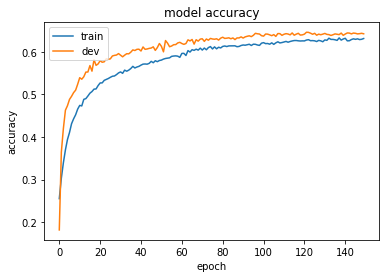

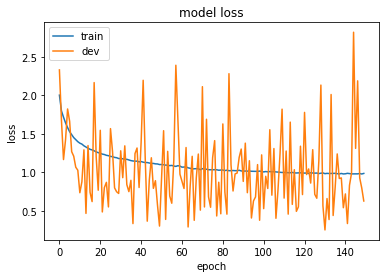

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [16]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
test_acc = '-test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/Colab Notebooks/models/' + 'SOA' + epoch_str + dropout_str + test_acc + '.h5')

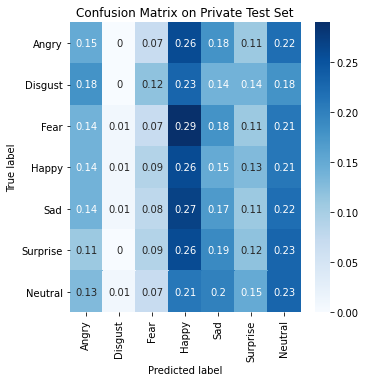

In [17]:
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

y_pred = model.predict_generator(dev_generator).argmax(axis=1)
y_true = dev_generator.classes

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Private Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
from sklearn.metrics import accuracy_score
# configure image data augmentation
datagen = ImageDataGenerator(horizontal_flip=True)

# make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, n_examples):
	# convert image into dataset
	samples = np.expand_dims(image, 0)
	# prepare iterator
	it = datagen.flow(samples, batch_size=n_examples)
	# make predictions for each augmented image
	yhats = model.predict_generator(it, steps=n_examples, verbose=0)
	# sum across predictions
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	return np.argmax(summed)
 
 # evaluate a model on a dataset using test-time augmentation
def tta_evaluate_model(model, testX, testY):
	# configure image data augmentation
	datagen = ImageDataGenerator(horizontal_flip=True)
	# define the number of augmented images to generate per test set image
	n_examples_per_image = 7
	yhats = list()
	for i in range(len(testX)):
		# make augmented prediction
		yhat = tta_prediction(datagen, model, testX[i], n_examples_per_image)
		# store for evaluation
		yhats.append(yhat)
	# calculate accuracy
	testY_labels = np.argmax(testY, axis=1)
	acc = accuracy_score(testY_labels, yhats)
	return acc

In [19]:
print('\n# Evaluate on test data')
#TTA_results_test = tta_evaluate_model(model, X_test, Y_test)
print('test loss, test acc:', results_test)
# print('TTA test acc:', TTA_results_test)


# Evaluate on test data
test loss, test acc: [0.9220175743103027, 0.6582754850387573]
